In [70]:
import pandas as pd
import numpy as np
import time
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [71]:
TRAIN_FILE_PATH = './archive/train.csv'

data = pd.read_csv(TRAIN_FILE_PATH)

In [72]:
iterations = 10

In [73]:
#Id en Name zijn niet relevant voor het model
data = data.drop(['PassengerId', 'Name'], axis=1)

In [74]:
data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [75]:
#print gemiddelde age van wel en niet getransporteerde mensen
print(data.groupby('Transported')['Age'].mean())
#Percentage vips per 
print(data.groupby('Transported')['VIP'].mean())
#Percentage van de mensen die getransporteerd zijn per destination
print(data.groupby('Destination')['Transported'].mean())

Transported
False    29.922858
True     27.748834
Name: Age, dtype: float64
Transported
False    0.029175
True     0.017782
Name: VIP, dtype: float64
Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
Name: Transported, dtype: float64


In [76]:
data = data.sample(frac=1)
train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]

train_x = train_data.drop(['Transported'], axis=1)
train_y = train_data['Transported']

test_x = test_data.drop(['Transported'], axis=1)
test_y = test_data['Transported']

#encode the data using sklearn.preprocessing.LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_x = train_x.apply(le.fit_transform)
test_x = test_x.apply(le.fit_transform)

In [77]:
param_grid = {'C': [0.1, 1, 10, 100],
                'degree': [0, 3, 6],
                'kernel':['poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, n_jobs=-1)

start = time.time()

grid.fit(train_x, train_y)

end = time.time()

print(f"Training time: {end - start}s")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training time: 121.31409549713135s


In [78]:
best_score = grid.best_score_
best_params = grid.best_params_

with open('result.txt', 'a') as f:
    f.write(f"GridSearch icm SVC\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

In [79]:
gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
31,1.951129,0.287823,0.385898,0.007480,100,3,rbf,"{'C': 100, 'degree': 3, 'kernel': 'rbf'}",0.764917,0.787922,0.787203,0.767793,0.787050,0.778977,0.010350,1
34,1.924560,0.196198,0.381693,0.007281,100,6,rbf,"{'C': 100, 'degree': 6, 'kernel': 'rbf'}",0.764917,0.787922,0.787203,0.767793,0.787050,0.778977,0.010350,1
28,1.905164,0.162198,0.379092,0.005014,100,0,rbf,"{'C': 100, 'degree': 0, 'kernel': 'rbf'}",0.764917,0.787922,0.787203,0.767793,0.787050,0.778977,0.010350,1
25,1.392028,0.118756,0.435654,0.021759,10,6,rbf,"{'C': 10, 'degree': 6, 'kernel': 'rbf'}",0.761323,0.785047,0.784328,0.764917,0.784173,0.775957,0.010547,4
22,1.298991,0.025940,0.415321,0.008815,10,3,rbf,"{'C': 10, 'degree': 3, 'kernel': 'rbf'}",0.761323,0.785047,0.784328,0.764917,0.784173,0.775957,0.010547,4


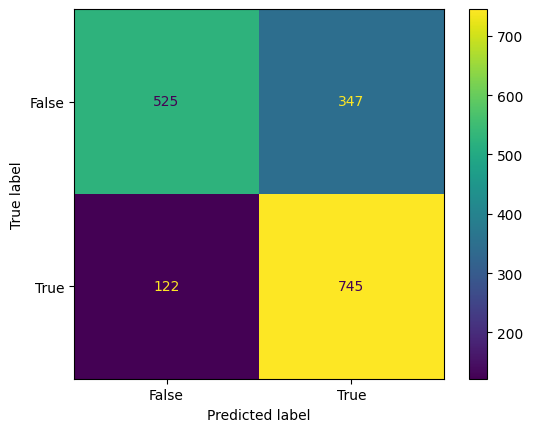

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)

In [81]:
#using random forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [10, 100, 1000],
              'max_depth': [None, 10, 100, 1000],
                'max_features': ['auto', 'sqrt', 'log2']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, n_jobs=-1)

start = time.time()
grid.fit(train_x, train_y)
end = time.time()

print(f"Training time: {end - start}s")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training time: 28.037057638168335s


In [82]:
best_score = grid.best_score_
best_params = grid.best_params_

print(f"Best score: {best_score}")

Best score: 0.7993972557396212


In [83]:
with open('result.txt', 'a') as f:
    f.write(f"GridSearch icm RandomForestClassifier\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

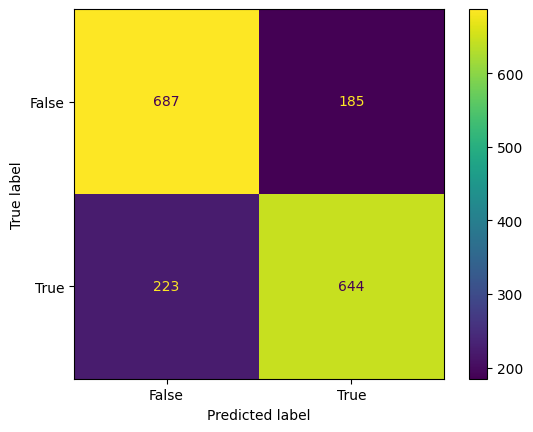

In [84]:
gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\ktmle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training time: 7.552610874176025s
Best score: 0.7982467972422925


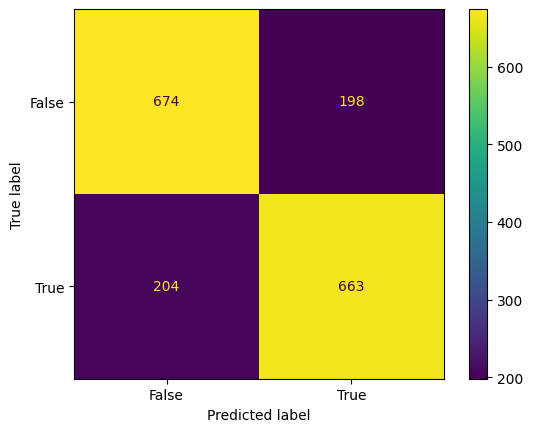

In [85]:
#RandomSearchCV icm RandomForest
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators': [10, 100, 1000],
                'max_depth': [None, 10, 100, 1000],
                    'max_features': ['auto', 'sqrt', 'log2']}

grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, n_jobs=-1, n_iter=iterations)

start = time.time()
grid.fit(train_x, train_y)
end = time.time()

print(f"Training time: {end - start}s")

best_score = grid.best_score_
best_params = grid.best_params_

print(f"Best score: {best_score}")

with open('result.txt', 'a') as f:
    f.write(f"RandomizedSearchCV icm RandomForest\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training time: 20.044560432434082s
Best score: 0.7759574655157254


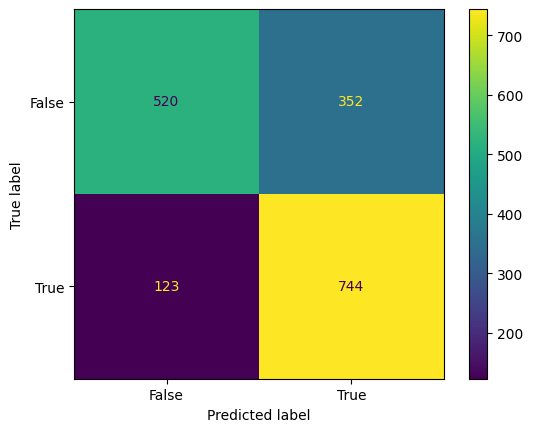

In [86]:
param_grid = {'C': [0.1, 1, 10, 100],
                'degree': [0, 3, 6],
                'kernel':['poly', 'rbf', 'sigmoid']}

grid = RandomizedSearchCV(SVC(), param_grid, refit=True, verbose=3, n_jobs=-1, n_iter=iterations)

start = time.time()
grid.fit(train_x, train_y)
end = time.time()

print(f"Training time: {end - start}s")

best_score = grid.best_score_
best_params = grid.best_params_

print(f"Best score: {best_score}")

with open('result.txt', 'a') as f:
    f.write(f"RandomizedSearchCV icm SVC\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 217
max_resources_: 6954
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 36
n_resources: 217
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 18
n_resources: 434
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 9
n_resources: 868
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 5
n_resources: 1736
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 3
n_resources: 3472
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 6944
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Training time: 17.732325792312622s
Best score: 0.7971181556195965


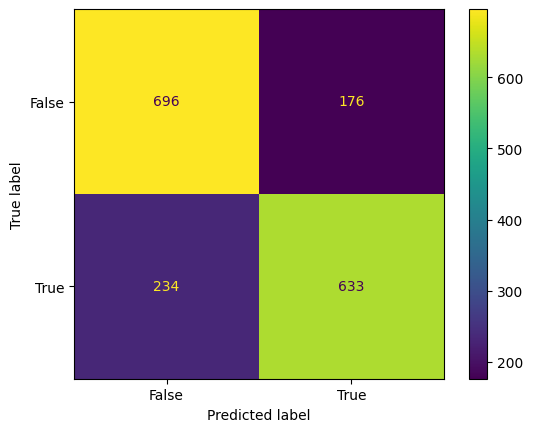

In [87]:
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {'n_estimators': [10, 100, 1000],
                'max_depth': [None, 10, 100, 1000],
                    'max_features': ['auto', 'sqrt', 'log2']}

grid = HalvingGridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, n_jobs=-1, factor=2)

start = time.time()

grid.fit(train_x, train_y)

end = time.time()

print(f"Training time: {end - start}s")

best_score = grid.best_score_
best_params = grid.best_params_

print(f"Best score: {best_score}")

with open('result.txt', 'a') as f:
    f.write(f"HalvingGridSearchCV icm RandomForest\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 9
min_resources_: 20
max_resources_: 6954
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 36
n_resources: 20
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ktmle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=347. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 18
n_resources: 40
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 9
n_resources: 80
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 5
n_resources: 160
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 3
n_resources: 320
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 640
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Training time: 8.660429954528809s
Best score: 0.7637303149606299


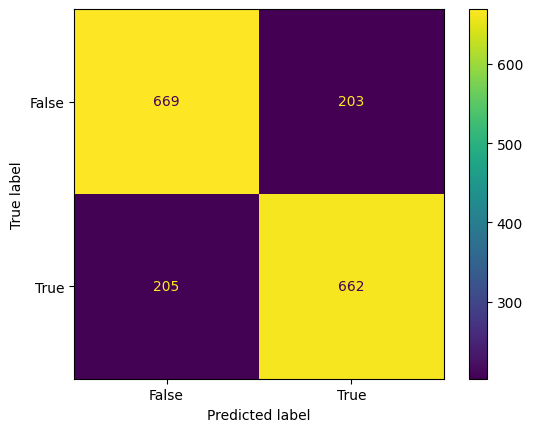

In [89]:
from sklearn.model_selection import HalvingRandomSearchCV

param_grid = {'n_estimators': [10, 100, 1000],
                'max_depth': [None, 10, 100, 1000],
                    'max_features': ['auto', 'sqrt', 'log2']}

grid = HalvingRandomSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, n_jobs=-1, factor=2)

start = time.time()

grid.fit(train_x, train_y)

end = time.time()

print(f"Training time: {end - start}s")

best_score = grid.best_score_
best_params = grid.best_params_

print(f"Best score: {best_score}")

with open('result.txt', 'a') as f:
    f.write(f"HalvingRandomSearchCV icm RandomForest\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)